# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('data/5guys_flight_data.csv')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27688\176002583.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/5guys_flight_data.csv')


In [5]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME_x,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,AIRLINE_ID,CARRIER_NAME,MANUFACTURE_YEAR,NUMBER_OF_SEATS,PLANE_AGE,DEPARTING_AIRPORT,ORIGIN_CITY_NAME_y,NAME_x,SEGMENT_NUMBER,PREVIOUS_AIRPORT,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME_y,STATION,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WESD,WT10,PSUN,TSUN,SN32,SX32,TOBS,WT11
0,1,28,1,UA,N13718,830,13930,ORD,"Chicago, IL",14262,PSP,"Palm Springs, CA",1028,1408.0,220.0,1.0,1000-1059,1306,1604.0,178.0,1300-1359,0.0,NaN,278.0,236.0,1652.0,7,178.0,0.0,0.0,0.0,0.0,NaN,19977,United Air Lines Inc.,1999.000000,124.0,21.000000,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1.0,NONE,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",USW00094846,2019-1-28,12.75,NaN,0.53,5.0,9.1,18.0,34.0,8.0,300.0,290.0,25.9,35.1,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,28,1,EV,N14902,4020,13930,ORD,"Chicago, IL",11193,CVG,"Cincinnati, OH",855,1029.0,94.0,1.0,0800-0859,1118,1324.0,126.0,1100-1159,0.0,NaN,83.0,115.0,264.0,2,0.0,0.0,126.0,0.0,0.0,NaN,20366,Atlantic Southeast Airlines,2007.151163,NaN,12.848837,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1.0,NONE,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",USW00094846,2019-1-28,12.75,NaN,0.53,5.0,9.1,18.0,34.0,8.0,300.0,290.0,25.9,35.1,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,28,1,UA,N56859,1942,13930,ORD,"Chicago, IL",11292,DEN,"Denver, CO",1011,1031.0,20.0,1.0,1000-1059,1200,1308.0,68.0,1200-1259,0.0,NaN,169.0,217.0,888.0,4,0.0,20.0,48.0,0.0,0.0,NaN,19977,United Air Lines Inc.,2004.000000,216.0,16.000000,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1.0,NONE,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",USW00094846,2019-1-28,12.75,NaN,0.53,5.0,9.1,18.0,34.0,8.0,300.0,290.0,25.9,35.1,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,28,1,UA,N37253,2043,13930,ORD,"Chicago, IL",12266,IAH,"Houston, TX",600,636.0,36.0,1.0,0600-0659,853,929.0,36.0,0800-0859,0.0,NaN,173.0,173.0,925.0,4,0.0,36.0,0.0,0.0,0.0,NaN,19977,United Air Lines Inc.,2000.000000,154.0,20.000000,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1.0,NONE,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",USW00094846,2019-1-28,12.75,NaN,0.53,5.0,9.1,18.0,34.0,8.0,300.0,290.0,25.9,35.1,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,28,1,UA,N57864,2005,13930,ORD,"Chicago, IL",11292,DEN,"Denver, CO",851,852.0,1.0,0.0,0800-0859,1040,1150.0,70.0,1000-1059,0.0,NaN,169.0,238.0,888.0,4,0.0,0.0,70.0,0.0,0.0,NaN,19977,United Air Lines Inc.,2001.000000,216.0,19.000000,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1.0,NONE,Chicago O'Hare International,"Chicago, IL","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",USW00094846,2019-1-28,12.75,NaN,0.53,5.0,9.1,18.0,34.0,8.0,300.0,290.0,25.9,35.1,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color='yellow'>**Handling Duplicates**</font>

In [5]:
print(df.shape)
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.shape)

12602

<font color='yellow'>**Checking for Null percentages**</font>

In [10]:
null_percentage = (df.isnull().mean() * 100).round(2)
print(null_percentage[null_percentage.sort_values(ascending=False)>95])

CANCELLATION_CODE     99.93
Unnamed: 32          100.00
WT02                  95.97
WT04                  99.45
WT05                  99.71
WT06                  99.16
WT07                  99.96
WT09                  99.65
WESD                  99.99
WT10                  99.99
PSUN                  99.73
TSUN                  99.73
SN32                  99.62
SX32                  99.62
TOBS                 100.00
WT11                 100.00
dtype: float64


In [10]:
df.drop(columns=['TOBS', 'Unnamed: 32','CANCELLATION_CODE','WT11'],inplace=True)
print(df.shape)

(6580707, 73)

<font color='yellow'>**Dropping Similar Columns by checking unique values**</font>

In [44]:
df.nunique()

MONTH                     12
DAY_OF_MONTH              31
DAY_OF_WEEK                7
OP_UNIQUE_CARRIER         17
TAIL_NUM                5881
OP_CARRIER_FL_NUM       7063
ORIGIN_AIRPORT_ID         96
ORIGIN                    96
ORIGIN_CITY_NAME_x        92
DEST_AIRPORT_ID          352
DEST                     352
DEST_CITY_NAME           344
CRS_DEP_TIME            1267
DEP_TIME                1439
DEP_DELAY_NEW           1472
DEP_DEL15                  2
DEP_TIME_BLK              19
CRS_ARR_TIME            1435
ARR_TIME                1440
ARR_DELAY_NEW           1448
ARR_TIME_BLK              19
CANCELLED                  2
CRS_ELAPSED_TIME         566
ACTUAL_ELAPSED_TIME      701
DISTANCE                1546
DISTANCE_GROUP            11
CARRIER_DELAY           1368
WEATHER_DELAY           1021
NAS_DELAY                991
SECURITY_DELAY           224
LATE_AIRCRAFT_DELAY      983
AIRLINE_ID                17
CARRIER_NAME              17
MANUFACTURE_YEAR          45
NUMBER_OF_SEAT

In [11]:
df.drop(columns=['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','AIRLINE_ID','STATION','MANUFACTURE_YEAR'],inplace = True)

<font color='yellow'>**Merging WT01 & WT02 to WT_Fog**</font>

In [12]:
print(((df['WT01'] == 1) | (df['WT02'] == 1)).sum())
df['WT_FOG'] = np.where((df['WT01'] == 1) | (df['WT02'] == 1), 1, 0)
print((df['WT_FOG'] == 1).sum())
df.drop(columns=['WT01','WT02'],inplace=True)

2279479


<font color='yellow'>**Creating Date and removing the extra columns**</font>

In [51]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df.loc[0,'DATE'].day_name()
df.drop(columns=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'],inplace=True)

'Monday'

<font color='yellow'>**WT has 1 unique value (1 if true and nan if not so filling nans with 0s)**</font>

In [20]:
df.nunique()

OP_UNIQUE_CARRIER         17
TAIL_NUM                5881
OP_CARRIER_FL_NUM       7063
ORIGIN                    96
ORIGIN_CITY_NAME_x        92
DEST                     352
DEST_CITY_NAME           344
CRS_DEP_TIME            1267
DEP_TIME                1439
DEP_DELAY_NEW           1472
DEP_DEL15                  2
DEP_TIME_BLK              19
CRS_ARR_TIME            1435
ARR_TIME                1440
ARR_DELAY_NEW           1448
ARR_TIME_BLK              19
CRS_ELAPSED_TIME         566
ACTUAL_ELAPSED_TIME      701
DISTANCE                1546
DISTANCE_GROUP            11
CARRIER_DELAY           1368
WEATHER_DELAY           1021
NAS_DELAY                991
SECURITY_DELAY           224
LATE_AIRCRAFT_DELAY      983
CARRIER_NAME              17
NUMBER_OF_SEATS           81
PLANE_AGE                 45
DEPARTING_AIRPORT         96
ORIGIN_CITY_NAME_y        93
NAME_x                    85
SEGMENT_NUMBER            15
PREVIOUS_AIRPORT          98
DISPLAY_AIRPORT_NAME      96
ORIGIN_CITY_NA

In [17]:
df['WT03'].fillna(0,inplace=True)
df['WT04'].fillna(0,inplace=True)
df['WT05'].fillna(0,inplace=True)
df['WT06'].fillna(0,inplace=True)
df['WT07'].fillna(0,inplace=True)
df['WT08'].fillna(0,inplace=True)
df['WT09'].fillna(0,inplace=True)
df['WT10'].fillna(0,inplace=True)
print(df.nunique())

OP_UNIQUE_CARRIER         17
TAIL_NUM                5881
OP_CARRIER_FL_NUM       7063
ORIGIN                    96
ORIGIN_CITY_NAME_x        92
DEST                     352
DEST_CITY_NAME           344
CRS_DEP_TIME            1267
DEP_TIME                1439
DEP_DELAY_NEW           1472
DEP_DEL15                  2
DEP_TIME_BLK              19
CRS_ARR_TIME            1435
ARR_TIME                1440
ARR_DELAY_NEW           1448
ARR_TIME_BLK              19
CANCELLED                  2
CRS_ELAPSED_TIME         566
ACTUAL_ELAPSED_TIME      701
DISTANCE                1546
DISTANCE_GROUP            11
CARRIER_DELAY           1368
WEATHER_DELAY           1021
NAS_DELAY                991
SECURITY_DELAY           224
LATE_AIRCRAFT_DELAY      983
CARRIER_NAME              17
NUMBER_OF_SEATS           81
PLANE_AGE                 45
DEPARTING_AIRPORT         96
ORIGIN_CITY_NAME_y        93
NAME_x                    85
SEGMENT_NUMBER            15
PREVIOUS_AIRPORT          98
DISPLAY_AIRPOR

<font color='yellow'>**We are only interested in delayed flights so dropping cencelled flights then dropping the "CANCELLED" column**</font>

In [18]:
df['CANCELLED'].value_counts()

CANCELLED
0.0    6576281
1.0       4426
Name: count, dtype: int64

In [23]:
df = df[df.CANCELLED != 1]
df.drop(columns=['CANCELLED'],inplace = True)

<font color='yellow'>**Filling the nan values**</font>

In [26]:
df.isna().sum().sort_values(ascending=False)

WESD                    6575754
TSUN                    6558781
PSUN                    6558445
SX32                    6551098
SN32                    6551098
PGTM                    6159917
NAS_DELAY               5314402
LATE_AIRCRAFT_DELAY     5314402
WEATHER_DELAY           5314402
SECURITY_DELAY          5314402
CARRIER_DELAY           5314402
SNWD                    2305034
SNOW                    2160485
TAVG                     930260
NUMBER_OF_SEATS          233526
ARR_DELAY_NEW             16985
ACTUAL_ELAPSED_TIME       16985
WDF5                      14335
WSF5                      14335
ARR_TIME                   2460
PRCP                       1986
TMIN                       1545
TMAX                       1213
AWND                        683
WSF2                         22
WDF2                         22
DATE                          0
WT03                          0
WT04                          0
WT05                          0
WT06                          0
WT07    

In [27]:
df.shape

(6576281, 63)

In [51]:
# Dropping rows that have nan values
df.dropna(subset=['DEP_DELAY_NEW','DEP_DEL15','ARR_TIME','ARR_DELAY_NEW','ACTUAL_ELAPSED_TIME','NUMBER_OF_SEATS','AWND','PRCP','TMAX','TMIN','WDF5','TAVG'], how='any',inplace=True)

# Dropping the columns with high nan percentage
df.drop(columns=['WESD','PSUN','PGTM','SX32','SN32','TSUN'],inplace=True)

df.isna().sum().sort_values(ascending=False)

LATE_AIRCRAFT_DELAY     4376148
SECURITY_DELAY          4376148
NAS_DELAY               4376148
WEATHER_DELAY           4376148
CARRIER_DELAY           4376148
SNWD                    1528826
SNOW                    1382569
OP_UNIQUE_CARRIER             0
TAVG                          0
DISPLAY_AIRPORT_NAME          0
ORIGIN_CITY_NAME              0
NAME_y                        0
DATE                          0
AWND                          0
PRCP                          0
TMAX                          0
SEGMENT_NUMBER                0
TMIN                          0
WDF2                          0
WDF5                          0
WSF2                          0
WSF5                          0
WT03                          0
WT04                          0
WT05                          0
WT06                          0
WT07                          0
WT08                          0
WT09                          0
WT10                          0
PREVIOUS_AIRPORT              0
DEPARTIN

In [50]:
condition = df['SNWD'].isna() | df['SNOW'].isna()
df[condition].shape
df.dropna(subset=['SNWD','SNOW'], how='any',inplace=True)

(1529144, 57)

In [53]:
df.isna().sum().sort_values(ascending=False)

LATE_AIRCRAFT_DELAY     3134690
SECURITY_DELAY          3134690
NAS_DELAY               3134690
WEATHER_DELAY           3134690
CARRIER_DELAY           3134690
OP_UNIQUE_CARRIER             0
TAVG                          0
DISPLAY_AIRPORT_NAME          0
ORIGIN_CITY_NAME              0
NAME_y                        0
DATE                          0
AWND                          0
PRCP                          0
SNOW                          0
SNWD                          0
TMAX                          0
SEGMENT_NUMBER                0
TMIN                          0
WDF2                          0
WDF5                          0
WSF2                          0
WSF5                          0
WT03                          0
WT04                          0
WT05                          0
WT06                          0
WT07                          0
WT08                          0
WT09                          0
WT10                          0
PREVIOUS_AIRPORT              0
DEPARTIN

In [59]:
print(df.fillna(0,inplace=True))
df.shape

(3887149, 57)

array([[<Axes: title={'center': 'OP_CARRIER_FL_NUM'}>,
        <Axes: title={'center': 'CRS_DEP_TIME'}>,
        <Axes: title={'center': 'DEP_TIME'}>,
        <Axes: title={'center': 'DEP_DELAY_NEW'}>,
        <Axes: title={'center': 'DEP_DEL15'}>,
        <Axes: title={'center': 'CRS_ARR_TIME'}>],
       [<Axes: title={'center': 'ARR_TIME'}>,
        <Axes: title={'center': 'ARR_DELAY_NEW'}>,
        <Axes: title={'center': 'CRS_ELAPSED_TIME'}>,
        <Axes: title={'center': 'ACTUAL_ELAPSED_TIME'}>,
        <Axes: title={'center': 'DISTANCE'}>,
        <Axes: title={'center': 'DISTANCE_GROUP'}>],
       [<Axes: title={'center': 'CARRIER_DELAY'}>,
        <Axes: title={'center': 'WEATHER_DELAY'}>,
        <Axes: title={'center': 'NAS_DELAY'}>,
        <Axes: title={'center': 'SECURITY_DELAY'}>,
        <Axes: title={'center': 'LATE_AIRCRAFT_DELAY'}>,
        <Axes: title={'center': 'NUMBER_OF_SEATS'}>],
       [<Axes: title={'center': 'PLANE_AGE'}>,
        <Axes: title={'center': 'S

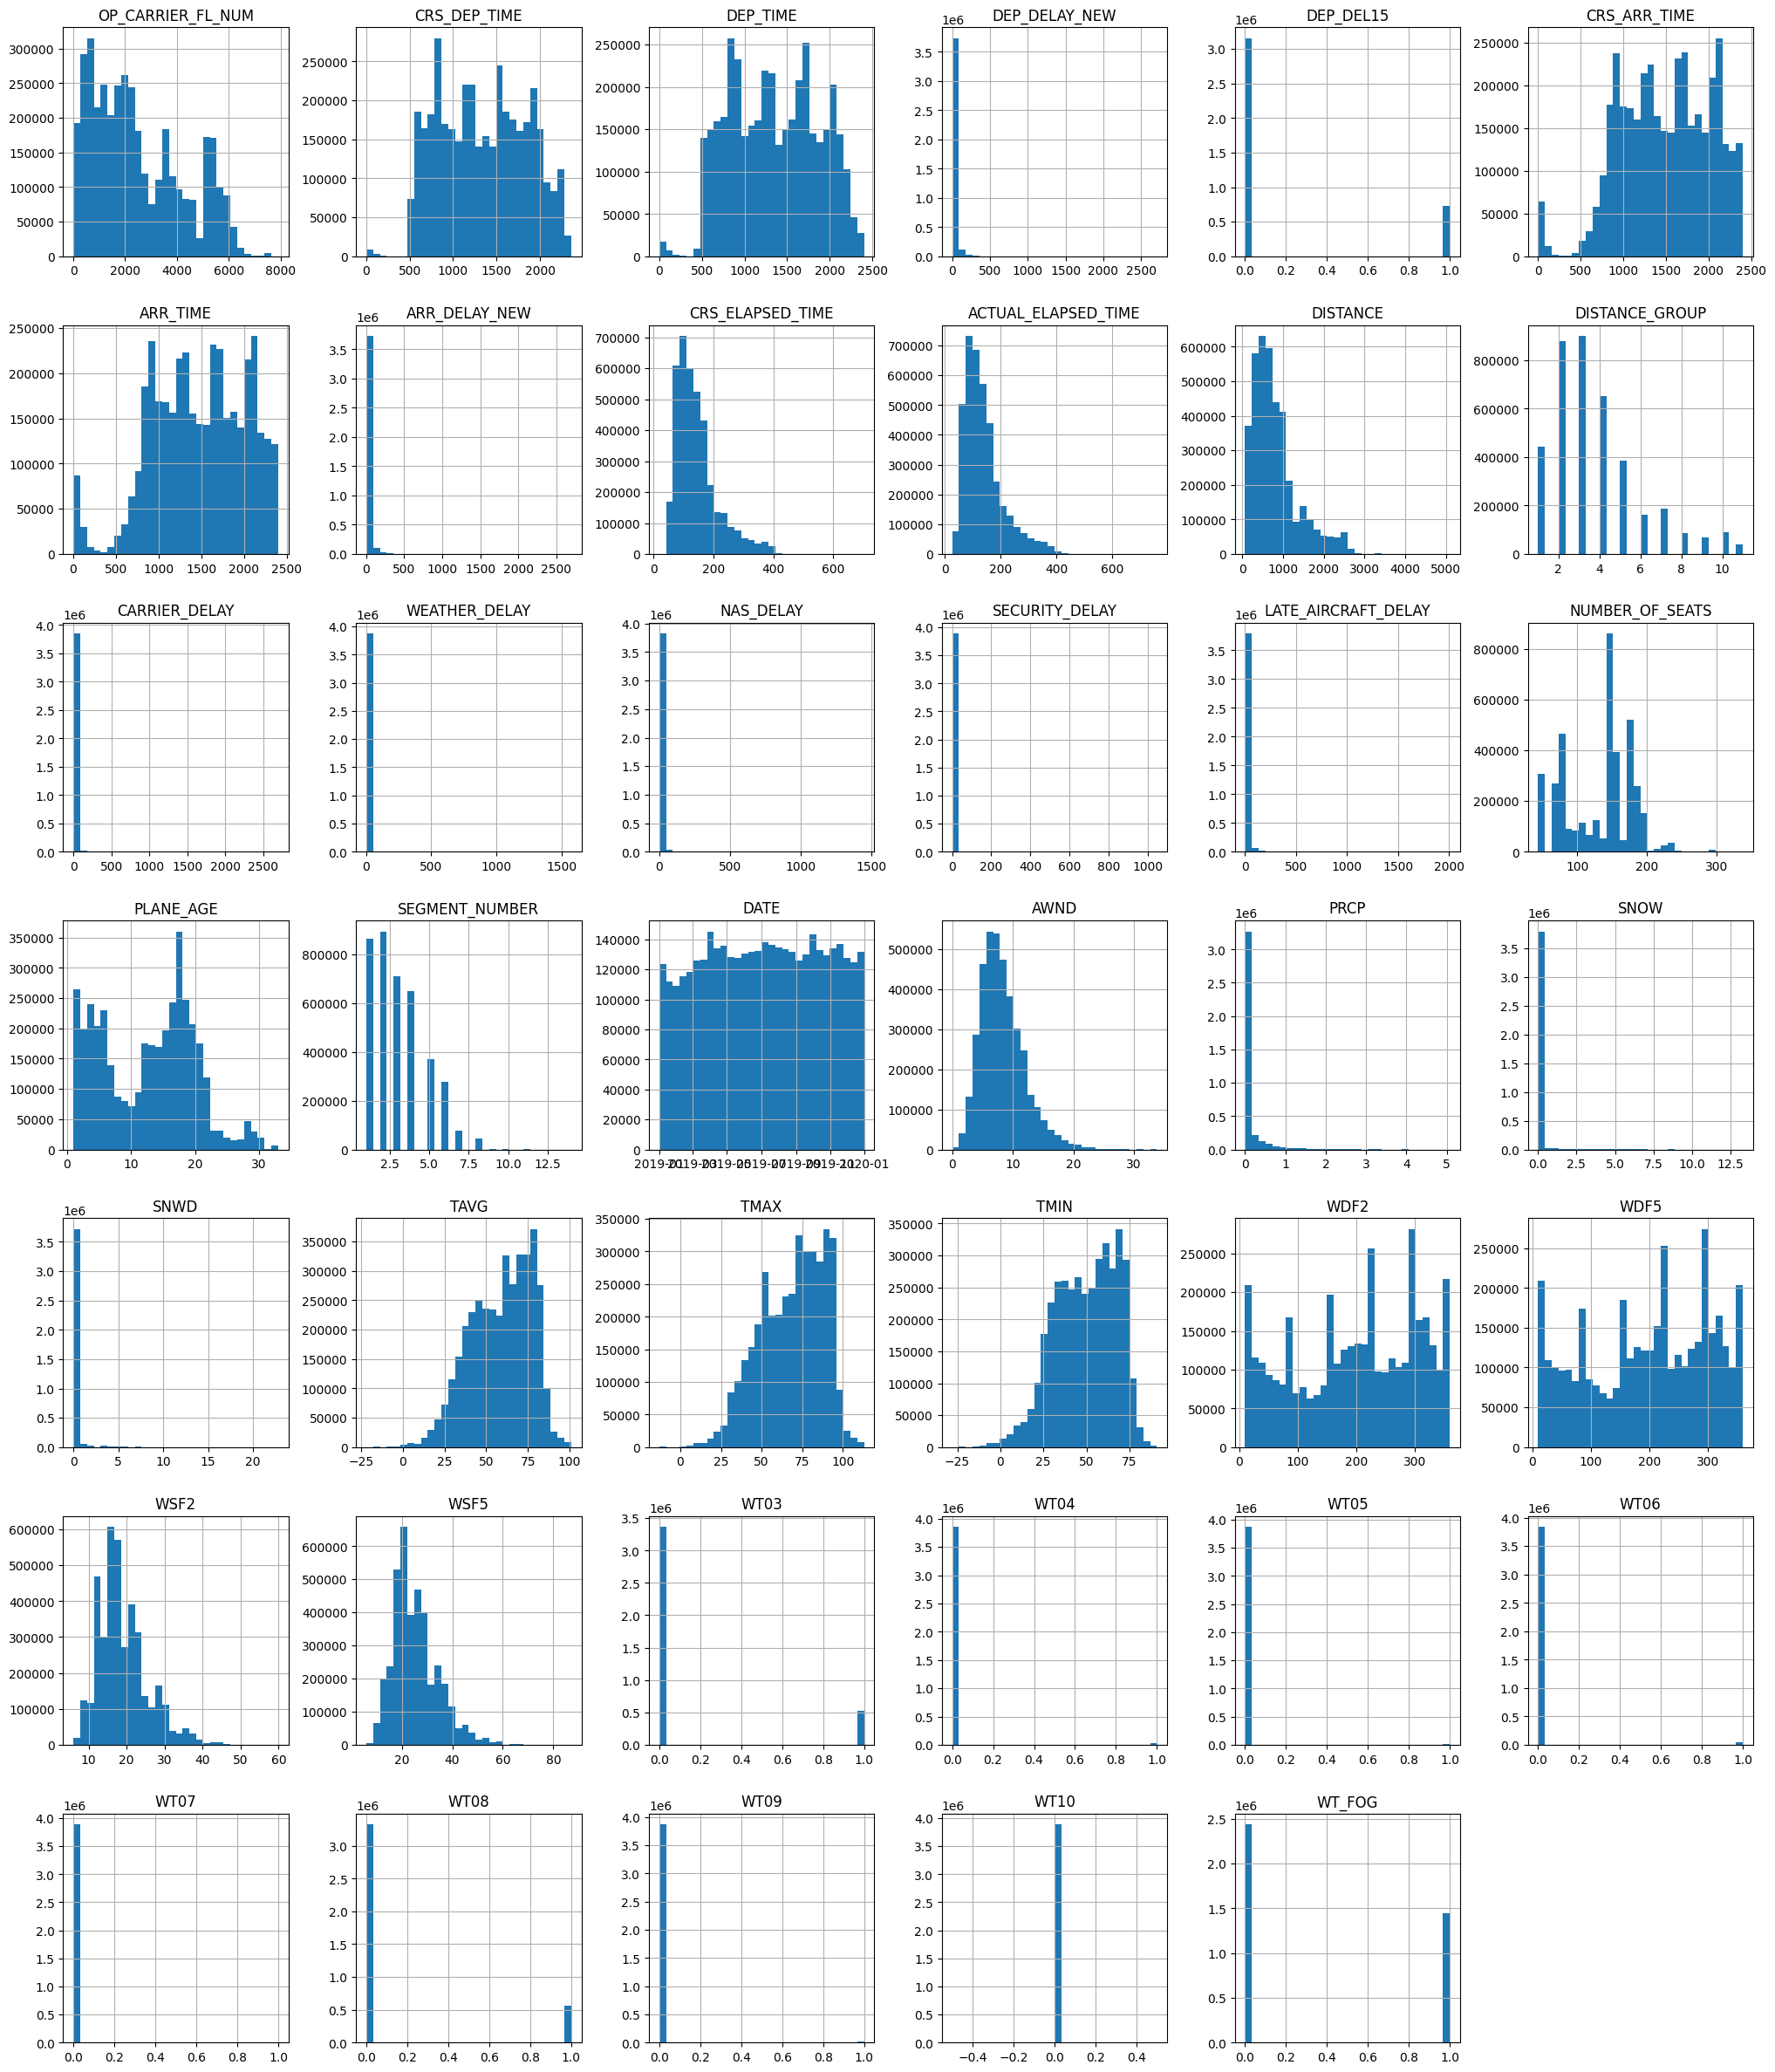

In [56]:
df.hist(bins=30, figsize=(25, 30))

In [58]:
df.to_csv('Cleaned.csv')

In [2]:
df = pd.read_csv('data/cleaned.csv')

In [3]:
df.head()

,Unnamed: 0,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME_x,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,...,WSF5,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT10,WT_FOG
0,0,UA,N13718,830,ORD,"Chicago, IL",PSP,"Palm Springs, CA",1028,1408.0,...,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1
1,2,UA,N56859,1942,ORD,"Chicago, IL",DEN,"Denver, CO",1011,1031.0,...,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1
2,3,UA,N37253,2043,ORD,"Chicago, IL",IAH,"Houston, TX",600,636.0,...,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1
3,4,UA,N57864,2005,ORD,"Chicago, IL",DEN,"Denver, CO",851,852.0,...,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1
4,5,UA,N68802,1996,ORD,"Chicago, IL",SJU,"San Juan, PR",754,834.0,...,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1


array([[<Axes: title={'center': 'OP_CARRIER_FL_NUM'}>,
        <Axes: title={'center': 'CRS_DEP_TIME'}>,
        <Axes: title={'center': 'DEP_TIME'}>,
        <Axes: title={'center': 'DEP_DELAY_NEW'}>,
        <Axes: title={'center': 'DEP_DEL15'}>,
        <Axes: title={'center': 'CRS_ARR_TIME'}>],
       [<Axes: title={'center': 'ARR_TIME'}>,
        <Axes: title={'center': 'ARR_DELAY_NEW'}>,
        <Axes: title={'center': 'CRS_ELAPSED_TIME'}>,
        <Axes: title={'center': 'ACTUAL_ELAPSED_TIME'}>,
        <Axes: title={'center': 'DISTANCE'}>,
        <Axes: title={'center': 'DISTANCE_GROUP'}>],
       [<Axes: title={'center': 'CARRIER_DELAY'}>,
        <Axes: title={'center': 'WEATHER_DELAY'}>,
        <Axes: title={'center': 'NAS_DELAY'}>,
        <Axes: title={'center': 'SECURITY_DELAY'}>,
        <Axes: title={'center': 'LATE_AIRCRAFT_DELAY'}>,
        <Axes: title={'center': 'NUMBER_OF_SEATS'}>],
       [<Axes: title={'center': 'PLANE_AGE'}>,
        <Axes: title={'center': 'S

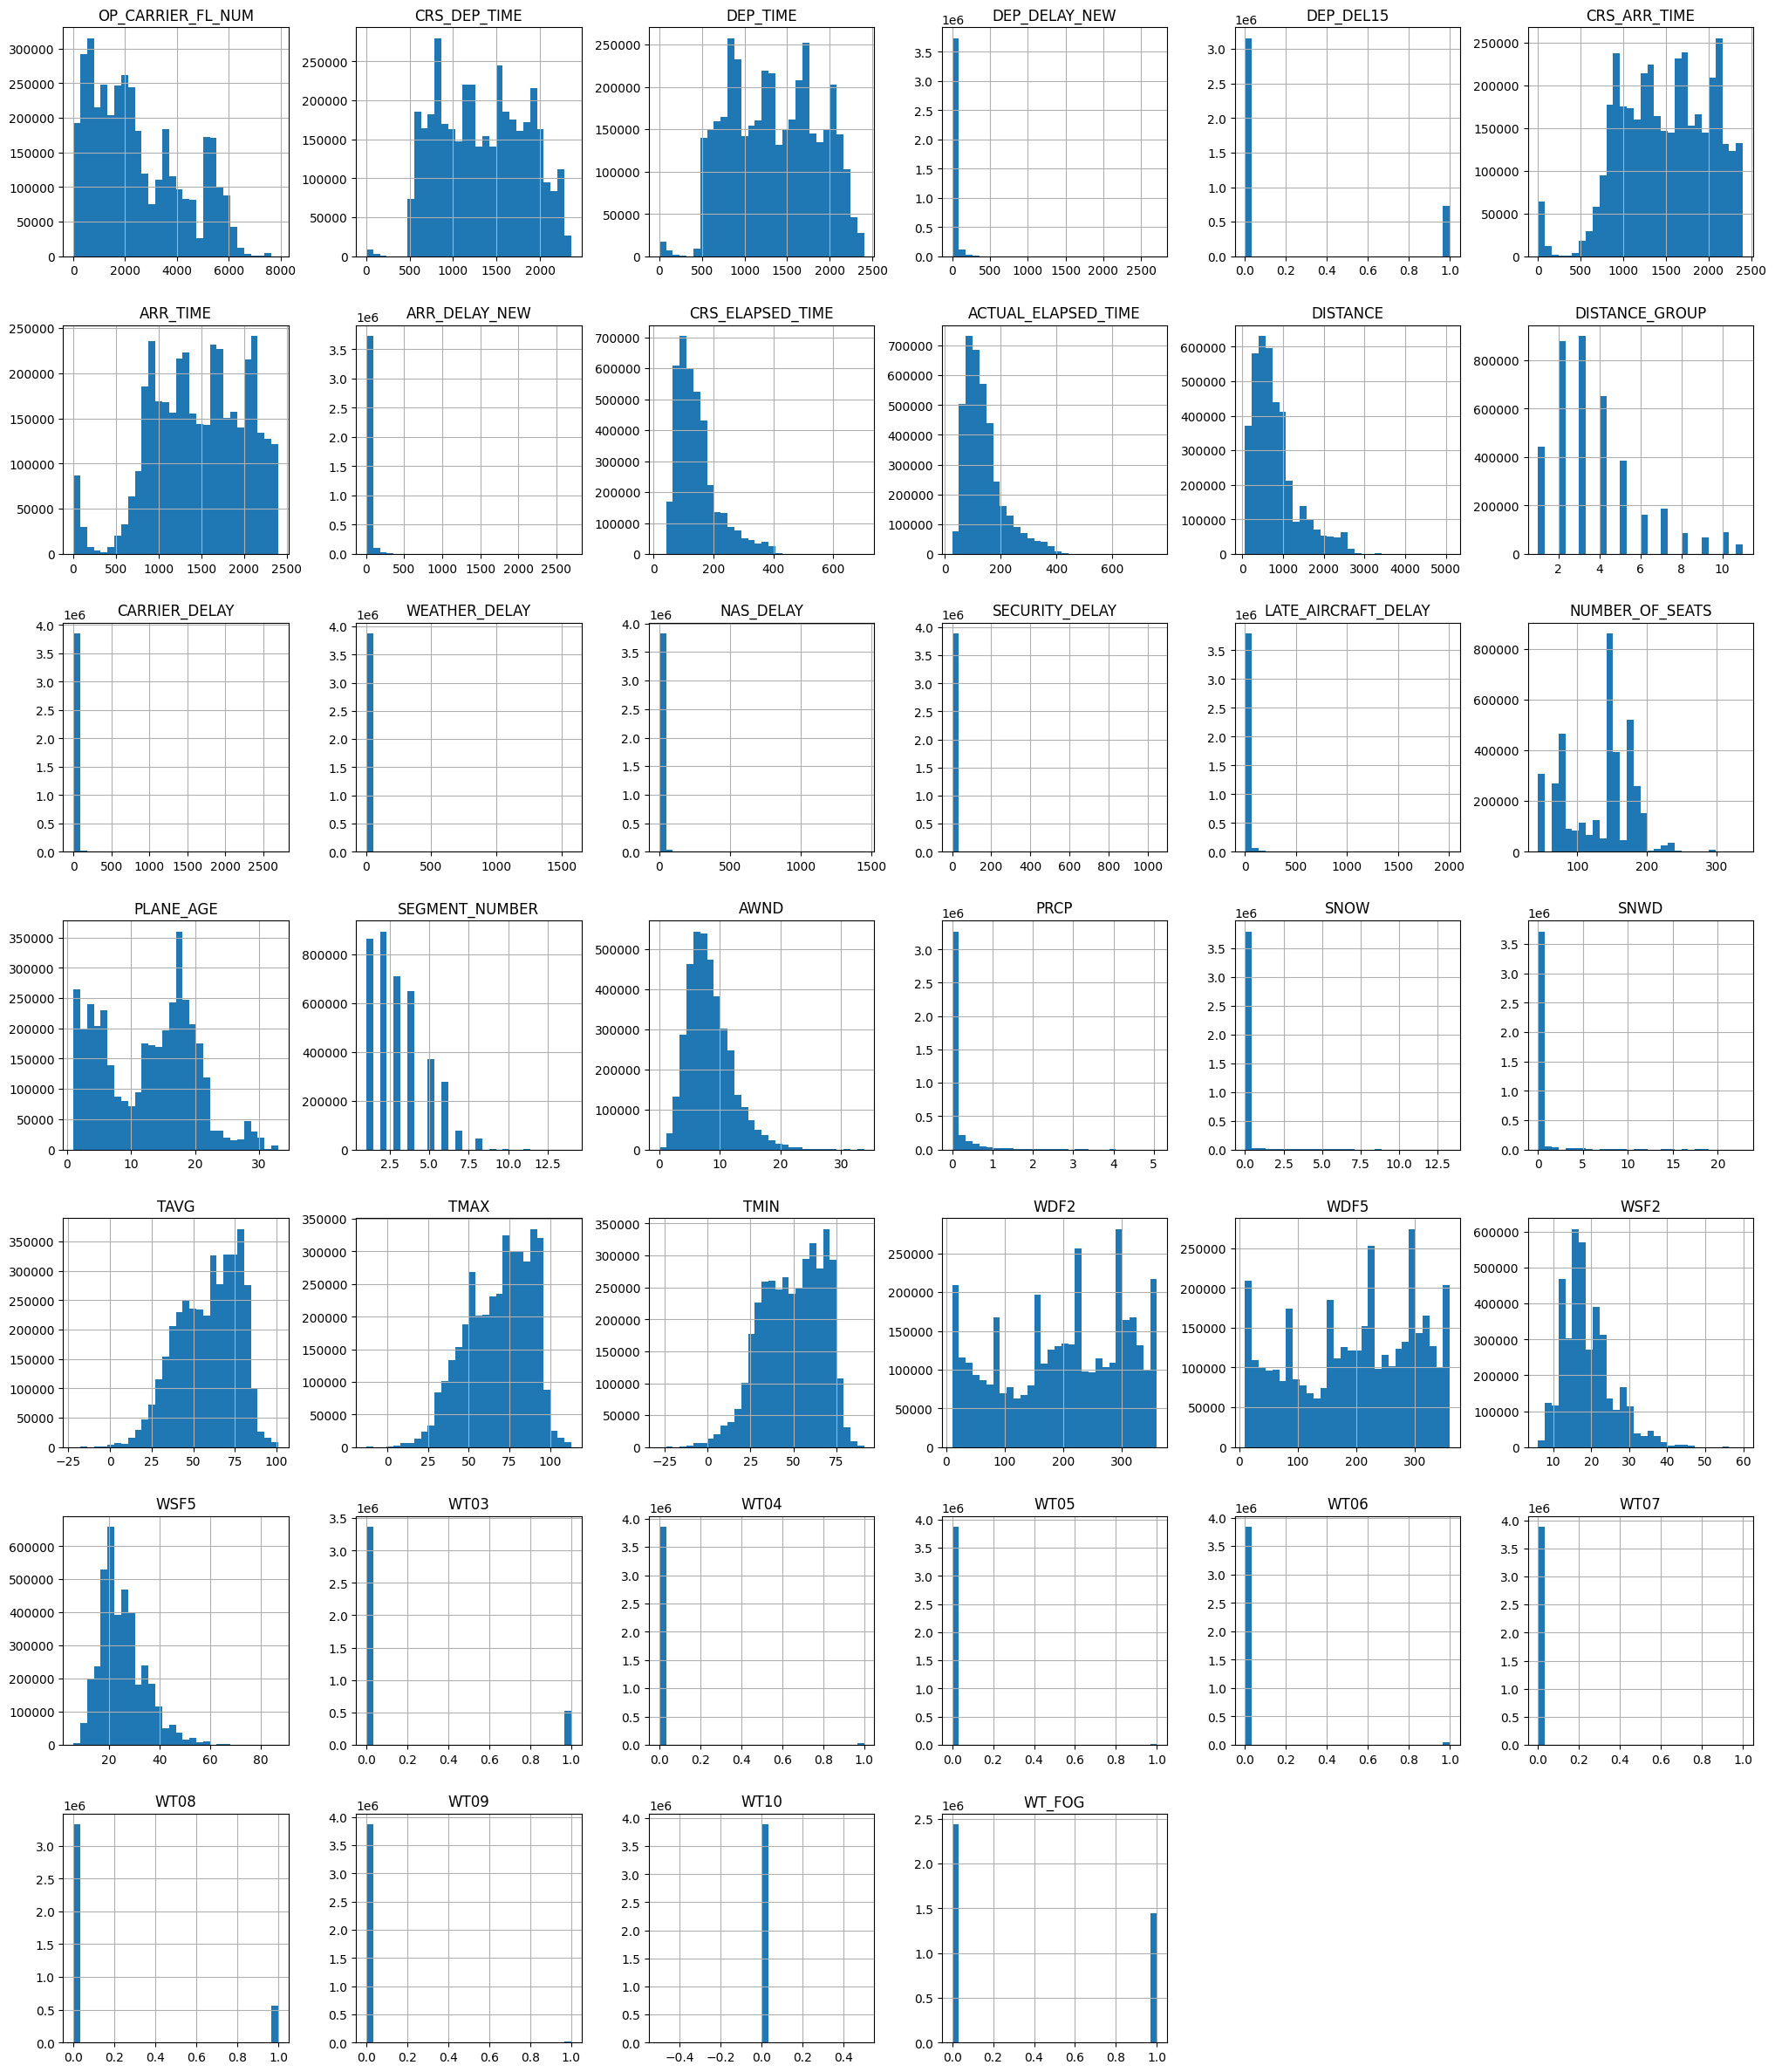

In [10]:
df.hist(bins=30, figsize=(25, 30))

In [9]:
df.drop(columns='Unnamed: 0',inplace=True)

In [14]:
percentage_of_zeros = (df.eq(0).mean() * 100).round(2)

# Print the column names along with the percentage of zeros
print(percentage_of_zeros.sort_values(ascending=False))

WT10                    100.00
WT07                     99.95
SECURITY_DELAY           99.94
WT05                     99.57
WT09                     99.47
WT04                     99.22
WEATHER_DELAY            98.82
WT06                     98.79
SNOW                     96.12
SNWD                     95.65
CARRIER_DELAY            90.46
LATE_AIRCRAFT_DELAY      90.06
NAS_DELAY                89.41
WT03                     86.60
WT08                     85.51
DEP_DEL15                81.17
PRCP                     67.27
ARR_DELAY_NEW            65.40
DEP_DELAY_NEW            64.78
WT_FOG                   62.71
TMIN                      0.02
TAVG                      0.01
AWND                      0.00
DATE                      0.00
NAME_y                    0.00
WDF2                      0.00
TMAX                      0.00
DISPLAY_AIRPORT_NAME      0.00
WDF5                      0.00
WSF2                      0.00
WSF5                      0.00
ORIGIN_CITY_NAME          0.00
OP_UNIQU

In [12]:
df['WT10'].value_counts()

WT10
0.0    3887149
Name: count, dtype: int64

In [15]:
df.drop(columns=['WT10','ACTUAL_ELAPSED_TIME','SECURITY_DELAY','WEATHER_DELAY','CARRIER_DELAY','LATE_AIRCRAFT_DELAY','NAS_DELAY','DEP_DELAY_NEW','ARR_DELAY_NEW'],inplace=True)

In [16]:
percentage_of_zeros = (df.eq(0).mean() * 100).round(2)

# Print the column names along with the percentage of zeros
print(percentage_of_zeros.sort_values(ascending=False))

WT07                    99.95
WT05                    99.57
WT09                    99.47
WT04                    99.22
WT06                    98.79
SNOW                    96.12
SNWD                    95.65
WT03                    86.60
WT08                    85.51
DEP_DEL15               81.17
PRCP                    67.27
WT_FOG                  62.71
TMIN                     0.02
TAVG                     0.01
AWND                     0.00
DATE                     0.00
NAME_y                   0.00
WDF5                     0.00
TMAX                     0.00
WDF2                     0.00
DISPLAY_AIRPORT_NAME     0.00
WSF2                     0.00
WSF5                     0.00
ORIGIN_CITY_NAME         0.00
OP_UNIQUE_CARRIER        0.00
TAIL_NUM                 0.00
ARR_TIME                 0.00
OP_CARRIER_FL_NUM        0.00
ORIGIN                   0.00
ORIGIN_CITY_NAME_x       0.00
DEST                     0.00
DEST_CITY_NAME           0.00
CRS_DEP_TIME             0.00
DEP_TIME  

In [17]:
df.head()

,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME_x,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,...,WSF2,WSF5,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT_FOG
0,UA,N13718,830,ORD,"Chicago, IL",PSP,"Palm Springs, CA",1028,1408.0,1.0,...,25.9,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1
1,UA,N56859,1942,ORD,"Chicago, IL",DEN,"Denver, CO",1011,1031.0,1.0,...,25.9,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1
2,UA,N37253,2043,ORD,"Chicago, IL",IAH,"Houston, TX",600,636.0,1.0,...,25.9,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1
3,UA,N57864,2005,ORD,"Chicago, IL",DEN,"Denver, CO",851,852.0,0.0,...,25.9,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1
4,UA,N68802,1996,ORD,"Chicago, IL",SJU,"San Juan, PR",754,834.0,1.0,...,25.9,35.1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1


In [21]:
df['ORIGIN_CITY_NAME_x']

0               Chicago, IL
1               Chicago, IL
2               Chicago, IL
3               Chicago, IL
4               Chicago, IL
                 ...       
3887144    Myrtle Beach, SC
3887145    Myrtle Beach, SC
3887146    Myrtle Beach, SC
3887147    Myrtle Beach, SC
3887148    Myrtle Beach, SC
Name: ORIGIN_CITY_NAME_x, Length: 3887149, dtype: object

In [23]:
df['ORIGIN_CITY_NAME_y']

0              Chicago, IL
1              Chicago, IL
2              Chicago, IL
3              Chicago, IL
4              Chicago, IL
                ...       
3887144    Minneapolis, MN
3887145    Minneapolis, MN
3887146    Minneapolis, MN
3887147    Minneapolis, MN
3887148    Minneapolis, MN
Name: ORIGIN_CITY_NAME_y, Length: 3887149, dtype: object

In [24]:
df['DEPARTING_AIRPORT']

0               Chicago O'Hare International
1               Chicago O'Hare International
2               Chicago O'Hare International
3               Chicago O'Hare International
4               Chicago O'Hare International
                         ...                
3887144    Minneapolis-St Paul International
3887145    Minneapolis-St Paul International
3887146    Minneapolis-St Paul International
3887147    Minneapolis-St Paul International
3887148    Minneapolis-St Paul International
Name: DEPARTING_AIRPORT, Length: 3887149, dtype: object

In [25]:
df['NAME_x']

0                 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US
1                 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US
2                 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US
3                 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US
4                 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US
                                 ...                        
3887144    MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US
3887145    MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US
3887146    MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US
3887147    MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US
3887148    MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US
Name: NAME_x, Length: 3887149, dtype: object

In [19]:
df.nunique()

OP_UNIQUE_CARRIER         16
TAIL_NUM                5522
OP_CARRIER_FL_NUM       7009
ORIGIN                    63
ORIGIN_CITY_NAME_x        60
DEST                     309
DEST_CITY_NAME           303
CRS_DEP_TIME            1250
DEP_TIME                1436
DEP_DEL15                  2
DEP_TIME_BLK              19
CRS_ARR_TIME            1412
ARR_TIME                1440
ARR_TIME_BLK              19
CRS_ELAPSED_TIME         500
DISTANCE                1331
DISTANCE_GROUP            11
CARRIER_NAME              16
NUMBER_OF_SEATS           81
PLANE_AGE                 33
DEPARTING_AIRPORT         63
ORIGIN_CITY_NAME_y        60
NAME_x                    56
SEGMENT_NUMBER            14
PREVIOUS_AIRPORT          97
DISPLAY_AIRPORT_NAME      63
ORIGIN_CITY_NAME          60
NAME_y                    56
DATE                     365
AWND                     128
PRCP                     261
SNOW                      81
SNWD                      27
TAVG                     118
TMAX          

In [26]:
df.drop(columns=['ORIGIN_CITY_NAME_x','ORIGIN_CITY_NAME_y','DEST_CITY_NAME','DEPARTING_AIRPORT','NAME_x','NAME_y'],inplace=True)

In [27]:
df.nunique()

OP_UNIQUE_CARRIER         16
TAIL_NUM                5522
OP_CARRIER_FL_NUM       7009
ORIGIN                    63
DEST                     309
CRS_DEP_TIME            1250
DEP_TIME                1436
DEP_DEL15                  2
DEP_TIME_BLK              19
CRS_ARR_TIME            1412
ARR_TIME                1440
ARR_TIME_BLK              19
CRS_ELAPSED_TIME         500
DISTANCE                1331
DISTANCE_GROUP            11
CARRIER_NAME              16
NUMBER_OF_SEATS           81
PLANE_AGE                 33
SEGMENT_NUMBER            14
PREVIOUS_AIRPORT          97
DISPLAY_AIRPORT_NAME      63
ORIGIN_CITY_NAME          60
DATE                     365
AWND                     128
PRCP                     261
SNOW                      81
SNWD                      27
TAVG                     118
TMAX                     121
TMIN                     114
WDF2                      36
WDF5                      38
WSF2                      46
WSF5                      69
WT03          

In [31]:
df['DISPLAY_AIRPORT_NAME']

0               Chicago O'Hare International
1               Chicago O'Hare International
2               Chicago O'Hare International
3               Chicago O'Hare International
4               Chicago O'Hare International
                         ...                
3887144    Minneapolis-St Paul International
3887145    Minneapolis-St Paul International
3887146    Minneapolis-St Paul International
3887147    Minneapolis-St Paul International
3887148    Minneapolis-St Paul International
Name: DISPLAY_AIRPORT_NAME, Length: 3887149, dtype: object

In [29]:
df['OP_UNIQUE_CARRIER']

0          UA
1          UA
2          UA
3          UA
4          UA
           ..
3887144    YX
3887145    OH
3887146    NK
3887147    9E
3887148    OH
Name: OP_UNIQUE_CARRIER, Length: 3887149, dtype: object

In [30]:
df['CARRIER_NAME']

0          United Air Lines Inc.
1          United Air Lines Inc.
2          United Air Lines Inc.
3          United Air Lines Inc.
4          United Air Lines Inc.
                   ...          
3887144    Midwest Airline, Inc.
3887145              Comair Inc.
3887146         Spirit Air Lines
3887147        Endeavor Air Inc.
3887148              Comair Inc.
Name: CARRIER_NAME, Length: 3887149, dtype: object

In [32]:
df.drop(columns=['CARRIER_NAME','ORIGIN_CITY_NAME'],inplace=True)

In [33]:
df.nunique()

OP_UNIQUE_CARRIER         16
TAIL_NUM                5522
OP_CARRIER_FL_NUM       7009
ORIGIN                    63
DEST                     309
CRS_DEP_TIME            1250
DEP_TIME                1436
DEP_DEL15                  2
DEP_TIME_BLK              19
CRS_ARR_TIME            1412
ARR_TIME                1440
ARR_TIME_BLK              19
CRS_ELAPSED_TIME         500
DISTANCE                1331
DISTANCE_GROUP            11
NUMBER_OF_SEATS           81
PLANE_AGE                 33
SEGMENT_NUMBER            14
PREVIOUS_AIRPORT          97
DISPLAY_AIRPORT_NAME      63
DATE                     365
AWND                     128
PRCP                     261
SNOW                      81
SNWD                      27
TAVG                     118
TMAX                     121
TMIN                     114
WDF2                      36
WDF5                      38
WSF2                      46
WSF5                      69
WT03                       2
WT04                       2
WT05          

In [34]:
df.drop(columns=['OP_CARRIER_FL_NUM','DISPLAY_AIRPORT_NAME'],inplace=True)

In [35]:
df.nunique()

OP_UNIQUE_CARRIER      16
TAIL_NUM             5522
ORIGIN                 63
DEST                  309
CRS_DEP_TIME         1250
DEP_TIME             1436
DEP_DEL15               2
DEP_TIME_BLK           19
CRS_ARR_TIME         1412
ARR_TIME             1440
ARR_TIME_BLK           19
CRS_ELAPSED_TIME      500
DISTANCE             1331
DISTANCE_GROUP         11
NUMBER_OF_SEATS        81
PLANE_AGE              33
SEGMENT_NUMBER         14
PREVIOUS_AIRPORT       97
DATE                  365
AWND                  128
PRCP                  261
SNOW                   81
SNWD                   27
TAVG                  118
TMAX                  121
TMIN                  114
WDF2                   36
WDF5                   38
WSF2                   46
WSF5                   69
WT03                    2
WT04                    2
WT05                    2
WT06                    2
WT07                    2
WT08                    2
WT09                    2
WT_FOG                  2
dtype: int64

In [36]:
df.drop(columns=['DEP_TIME','DEP_TIME_BLK','ARR_TIME','ARR_TIME_BLK'],inplace=True)

In [37]:
df.nunique()

OP_UNIQUE_CARRIER      16
TAIL_NUM             5522
ORIGIN                 63
DEST                  309
CRS_DEP_TIME         1250
DEP_DEL15               2
CRS_ARR_TIME         1412
CRS_ELAPSED_TIME      500
DISTANCE             1331
DISTANCE_GROUP         11
NUMBER_OF_SEATS        81
PLANE_AGE              33
SEGMENT_NUMBER         14
PREVIOUS_AIRPORT       97
DATE                  365
AWND                  128
PRCP                  261
SNOW                   81
SNWD                   27
TAVG                  118
TMAX                  121
TMIN                  114
WDF2                   36
WDF5                   38
WSF2                   46
WSF5                   69
WT03                    2
WT04                    2
WT05                    2
WT06                    2
WT07                    2
WT08                    2
WT09                    2
WT_FOG                  2
dtype: int64

In [39]:
df.shape

(3887149, 34)

In [40]:
print(df.duplicated().sum())

0


In [ ]:
target_variable = 'DEP_DEL15'
correlation_with_target = df.corr()[target_variable].sort_values(ascending=False)

## Preprocessing

In [ ]:
print("Let's preprocess")
print("NO")

Let's preprocess


## Training

## Evaluation